# 互评作业2: 频繁模式与关联规则挖掘

程序所在代码仓库地址：[Github](https://github.com/ZhangYHe/BIT-DataMining-2024)

## 1. 要求

### 1.1 问题描述

本次作业中，将选择2个数据集进行分析与挖掘

### 1.2. 可选数据集

来源包括：

- SNAP(Stanford Large Network Dataset Collection): http://snap.stanford.edu/data/index.html
- Microsoft 资讯推荐:  https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets
- YELP: https://www.yelp.com/dataset/download
- DBLP: https://dblp.uni-trier.de/xml/

### 1.3. 数据分析要求

- 数据获取与预处理；
- 频繁模式挖掘：可以是项集、序列和图。
- 模式命名：如论文-作者网络中合作模式、引用模式和发表模式等，不同的领域的频繁模式的含义也不尽相同，需自行确定模式的名称。
- 对挖掘结果进行分析；
- 可视化展示。

### 1.4. 提交的内容

- 数据集获取和预处理的代码
- 关联规则挖掘的代码
- 挖掘过程的报告：展示挖掘的过程、结果和你的分析
- 所选择的数据集在README中说明，数据文件不要上传到Github中


## 2. Microsoft资讯推荐数据集

数据集为[Microsoft资讯推荐数据集](https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets)

In [44]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import requests
import os
import networkx as nx

### 2.1 数据获取与预处理


#### 2.1.1 数据获取

下载MIND数据集

In [45]:
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [46]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None

    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [47]:
zip_path = download_url(training_small_url, destination_filename="/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/MicrosoftNews/MINDsmall_train.zip", verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_train.zip


['behaviors.tsv', 'news.tsv', 'entity_embedding.vec', 'relation_embedding.vec']

#### 2.1.2 数据预处理

以behaviors.tsv为例

behaviors.tsv 文件包含印象日志和用户的新闻点击历史记录。 该文件具有五列，用制表符分隔：

- 印象 ID。 映像的 ID。
- 用户 ID。 用户的匿名 ID。
- 时间。 印象时间，格式为“MM/DD/YYYY HH:MM:SS AM/PM”。
- “历史记录”。 此用户在此映像之前的新闻点击历史记录（已点击新闻的 ID 列表）。
- 映像。 此印象中显示的新闻列表和用户对这些新闻的点击行为（1 表示点击，0 表示非点击）。


In [48]:
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
MIND_data = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])


In [49]:
MIND_data

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...,...
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


分割历史记录和映像列，处理可能的NaN值。将history和impressions转换为列表，便于后续处理。

In [50]:
# 解析时间列
MIND_data['time'] = pd.to_datetime(MIND_data['time'], format='%m/%d/%Y %I:%M:%S %p')

# 分割历史记录和映像列，处理可能的NaN值
MIND_data['history'] = MIND_data['history'].apply(lambda x: x.split() if isinstance(x, str) else [])
MIND_data['impressions'] = MIND_data['impressions'].apply(lambda x: [item.split('-') for item in x.split()] if isinstance(x, str) else [])


In [51]:

# 查看处理后的数据
MIND_data.head()


,impression_id,user_id,time,history,impressions
0,1,U13740,2019-11-11 09:05:58,"[N55189, N42782, N34694, N45794, N18445, N6330...","[[N55689, 1], [N35729, 0]]"
1,2,U91836,2019-11-12 18:11:30,"[N31739, N6072, N63045, N23979, N35656, N43353...","[[N20678, 0], [N39317, 0], [N58114, 0], [N2049..."
2,3,U73700,2019-11-14 07:01:48,"[N10732, N25792, N7563, N21087, N41087, N5445,...","[[N50014, 0], [N23877, 0], [N35389, 0], [N4971..."
3,4,U34670,2019-11-11 05:28:05,"[N45729, N2203, N871, N53880, N41375, N43142, ...","[[N35729, 0], [N33632, 0], [N49685, 1], [N2758..."
4,5,U8125,2019-11-12 16:11:21,"[N10078, N56514, N14904, N33740]","[[N39985, 0], [N36050, 0], [N16096, 0], [N8400..."


### 2.2 频繁模式挖掘

设置最小支持度阈值为0.03

In [52]:
# 提取历史记录作为事务数据
transactions = list(MIND_data['history'])

# 使用 TransactionEncoder 转换数据
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets = apriori(df, min_support=0.03, use_colnames=True)


In [53]:

# 查看频繁项集
frequent_itemsets

,support,itemsets
0,0.045966,(N10059)
1,0.030829,(N10897)
2,0.035696,(N11005)
3,0.037085,(N11101)
4,0.034466,(N11231)
...,...,...
87,0.043379,(N64273)
88,0.034899,(N64467)
89,0.048208,(N8148)
90,0.043710,(N8448)


In [54]:
# 使用 TransactionEncoder 转换数据
# te = TransactionEncoder()
# te_ary = te.fit(MIND_data['history']).transform(MIND_data['history'])
# df = pd.DataFrame(te_ary, columns=te.columns_)

# # 使用 apriori 算法找到频繁项集，设置最小支持度为 0.03
# frequent_itemsets = apriori(df, min_support=0.02, use_colnames=True)

# # 筛选至少包含两个新闻ID的频繁项集
# frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]

# print(frequent_itemsets)

提取 impressions 列并只考虑点击的新闻，设置最小支持度为0.01，频繁项集为空。这是由于impressions 数据中的新闻ID分布非常广泛，每个新闻ID只在很少的事务中出现，这会导致很难找到频繁出现的模式。这种情况在新闻推荐系统中很常见，因为通常有大量的新闻ID，但每个用户只点击了其中一小部分。

In [55]:
# 提取 impressions 列并只考虑点击的新闻
transactions_impressions = [
    [item[0] for item in impression if item[1] == 1]
    for impression in MIND_data['impressions']
]

# 使用 TransactionEncoder 转换数据
te_imp = TransactionEncoder()
te_imp_ary = te_imp.fit(transactions_impressions).transform(transactions_impressions)
df_imp = pd.DataFrame(te_imp_ary, columns=te_imp.columns_)

# 使用 apriori 算法找到频繁项集
frequent_itemsets_impressions = apriori(df_imp, min_support=0.001, use_colnames=True)



In [56]:

# 查看频繁项集
frequent_itemsets_impressions

,support,itemsets


### 2.3 模式命名

对于MIND数据集，进行模式命名。

1. 点击模式

定义：用户倾向于点击某些新闻组合的频繁模式。例如，如果频繁项集显示新闻 N55689 和 N42782 经常一起被点击，这可以被命名为一个特定的点击模式

这有助于识别哪些新闻类型或主题经常一起被阅读，进而可以优化新闻的捆绑推荐或相似新闻的推送。

2. 兴趣聚集模式

定义：反映了用户对特定新闻主题或类型的集中兴趣。比如，如果一个用户经常点击与科技相关的新闻，那么这种模式可以揭示出用户的主题偏好。

有助于个性化推荐系统精准定位用户兴趣点，提高推荐的相关性和用户满意度。

3. 交互动态模式
   
定义：基于用户与新闻互动的时间和顺序，识别出的模式。例如，用户在工作日早上可能倾向于阅读财经新闻，在周末则偏向于娱乐或生活类新闻。

可以用来优化新闻的推送时机，以适应用户的日常阅读习惯和偏好变化。

4. 历史偏好模式

定义：根据用户过去的历史记录，发现的阅读偏好模式。这可能包括长期对某些类型新闻的偏好或对特定新闻源的忠诚。

长期历史数据的分析有助于构建更为精准的用户画像，提高新闻推荐的准确性。

### 2.4 对挖掘结果进行分析

提取 impressions 列并只考虑点击的新闻，设置最小支持度为0.01，频繁项集为空。这是由于impressions 数据中的新闻ID分布非常广泛，每个新闻ID只在很少的事务中出现，这会导致很难找到频繁出现的模式。这种情况在新闻推荐系统中很常见，因为通常有大量的新闻ID，但每个用户只点击了其中一小部分。

### 2.5 可视化展示

- 条形图 侧重于展示最常见的新闻组合和它们的支持度，这有助于识别用户兴趣的主要趋势。
- 热图 展示了新闻ID之间的共现频率，有助于理解新闻间的潜在关联，可能对新闻聚类和推荐系统的改进有重要意义。

    News ID  Frequency
175    N306      20765
287  N42620      17918
8    N31801      15694
69   N47020      15216
3    N45794      15200
111  N43142      14565
108    N871      14210
0    N55189      13394
903  N29177      13243
218  N16715      13011


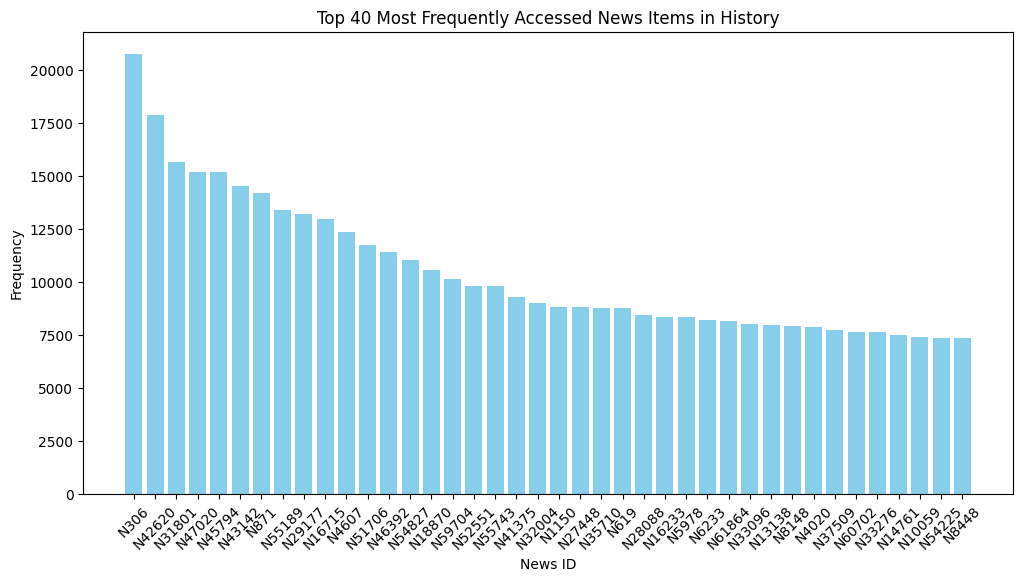

In [57]:
# 将所有历史点击合并到一个列表中
all_history = [news_id for sublist in MIND_data['history'] for news_id in sublist]

# 计算每个新闻ID的频率
news_frequency = Counter(all_history)

# 将频率数据转换为DataFrame进行排序和可视化
news_freq_df = pd.DataFrame(news_frequency.items(), columns=['News ID', 'Frequency'])
news_freq_df = news_freq_df.sort_values(by='Frequency', ascending=False)

# 显示最常被点击的前10条新闻
print(news_freq_df.head(10))

# 可视化最常被点击的新闻ID
plt.figure(figsize=(12, 6))
plt.bar(news_freq_df['News ID'].head(40), news_freq_df['Frequency'].head(40), color='skyblue')
plt.xlabel('News ID')
plt.ylabel('Frequency')
plt.title('Top 40 Most Frequently Accessed News Items in History')
plt.xticks(rotation=45)
plt.show()

In [58]:
# 提取历史记录作为事务数据
transactions = list(MIND_data['history'])

# 使用 TransactionEncoder 转换数据
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets = apriori(df, min_support=0.03, use_colnames=True)

In [59]:
# # 从 TransactionEncoder 的结果构建关联矩阵
# assoc_matrix = np.dot(te_ary.T, te_ary)
# np.fill_diagonal(assoc_matrix, 0)  # 将对角线元素设置为0，避免自关联影响可视化效果

# # 将关联矩阵转换为 DataFrame
# assoc_matrix_df = pd.DataFrame(assoc_matrix, index=te.columns_, columns=te.columns_)

# # 创建热图
# plt.figure(figsize=(12, 10))
# sns.heatmap(assoc_matrix_df, annot=False, cmap='Blues', xticklabels=True, yticklabels=True)
# plt.title('Heatmap of News ID Associations from History')
# plt.xlabel('News ID')
# plt.ylabel('News ID')
# plt.show()

## 3. SNAP数据集

下载[SNAP数据集](http://snap.stanford.edu/data/index.html)，以Social circles: Facebook为样例进行处理。

### 3.1 数据获取与预处理

#### 3.1.1 数据获取

In [60]:
def download_file(url, target_path):
    # 检查目标文件是否已存在
    if os.path.exists(target_path):
        print("文件已存在，跳过下载。")
    else:
        # 尝试从URL下载文件
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()  
            
            with open(target_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("文件下载成功。")
        except requests.exceptions.RequestException as e:
            print(f"下载失败：{e}")


url = 'https://snap.stanford.edu/data/facebook.tar.gz'
target_path = '/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/SNAP/Social circles-Facebook/facebook.tar.gz'
download_file(url, target_path)

文件已存在，跳过下载。


#### 3.1.2 数据预处理

In [61]:
# 读取边信息
edges_path = '/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/SNAP/Social circles-Facebook/facebook_combined.txt'
edges_df = pd.read_csv(edges_path, delim_whitespace=True, header=None, names=['source', 'target'])

edges_df.head()

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [62]:
# 创建无向图
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

# 输出网络的基本信息
print(nx.info(G))

Graph with 4039 nodes and 88234 edges


### 3.2 频繁模式挖掘

In [63]:
def read_circles(base_path, file_name):
    path = os.path.join(base_path, file_name)
    with open(path, 'r') as file:
        circles = {}
        for line in file:
            parts = line.strip().split()
            circles[parts[0]] = parts[1:]
    return circles

base_path = '/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/SNAP/Social circles-Facebook/facebook'
circles = read_circles(base_path, '0.circles')

In [64]:
def read_features(base_path, file_name):
    path = os.path.join(base_path, file_name)
    return pd.read_csv(path, delim_whitespace=True, header=None)

features = read_features(base_path, '0.feat')


要进行SNAP数据集的频繁模式挖掘，首先我们需要理解数据结构和决定想要寻找什么样的频繁模式。SNAP数据集是一个社交网络数据集，包含节点（用户）、边（社交关系）、用户特征等信息。我们可以探索以下几种频繁模式挖掘的方向：

频繁交互模式：在网络中发现经常一起出现在边中的节点组合。

频繁特征模式：查找具有相似特征的节点集合。

圈子成员模式：分析哪些节点（用户）经常出现在同一个圈子中。

1. 读取边数据并进行频繁交互模式挖掘
   
我们首先读取边文件，构建网络，并使用Apriori算法寻找频繁交互的节点组。

In [65]:
# 读取边数据
edges_path = '/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/SNAP/Social circles-Facebook/facebook/0.edges'
edges_df = pd.read_csv(edges_path, delim_whitespace=True, header=None, names=['node1', 'node2'])

# 创建无向图
G = nx.from_pandas_edgelist(edges_df, 'node1', 'node2')

# 提取邻接矩阵
adj_matrix = nx.to_numpy_array(G, dtype=bool)

# 使用TransactionEncoder转换数据
te = TransactionEncoder()
te_ary = te.fit_transform(adj_matrix)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 执行Apriori算法
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,1.0,(False)
1,1.0,(True)
2,1.0,"(False, True)"


2. 分析特征文件以找到频繁特征模式

我们读取特征文件，然后使用Apriori算法找出具有相似特征的节点集

In [66]:
# 假设 feat_df 已经加载
feat_path = '/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/SNAP/Social circles-Facebook/facebook/0.feat'
feat_df = pd.read_csv(feat_path, delim_whitespace=True, header=None)

# 删除节点ID列，转换剩余的每一行为一个特征列表
def process_features(row):
    # 返回具有'1'的特征列的索引
    return [str(idx) for idx, value in enumerate(row) if value == 1]

# 适用于所有行，假定第一列是节点ID，应从特征数据中排除
transactional_data = feat_df.iloc[:, 1:].apply(process_features, axis=1).tolist()

# 使用TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit_transform(transactional_data)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 使用Apriori算法找频繁项集
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.011527,(0)
1,0.023055,(1)
2,0.046110,(100)
3,0.057637,(101)
4,0.011527,(102)
...,...,...
36046,0.011527,"(7, 55, 138, 65, 14, 59, 53, 50, 92, 78)"
36047,0.011527,"(185, 55, 138, 14, 59, 53, 173, 50, 127, 92, 78)"
36048,0.011527,"(55, 138, 65, 14, 59, 53, 173, 50, 127, 92, 78)"
36049,0.011527,"(185, 55, 138, 65, 14, 59, 53, 50, 127, 92, 78)"


3. 圈子数据的频繁模式挖掘
   
最后，我们读取圈子数据并分析哪些节点经常出现在同一个圈子中。

In [67]:
# 读取圈子数据
circle_path = '/Users/zhangyunhe/Files/homework/数据挖掘/BIT-DataMining-2024/data/SNAP/Social circles-Facebook/facebook/0.circles'
with open(circle_path, 'r') as file:
    circles = [line.strip().split()[1:] for line in file]

# 使用TransactionEncoder转换数据
te_circle = TransactionEncoder()
te_ary_circle = te_circle.fit_transform(circles)
df_circle = pd.DataFrame(te_ary_circle, columns=te_circle.columns_)

# 执行Apriori算法
frequent_circle_itemsets = apriori(df_circle, min_support=0.05, use_colnames=True)
frequent_circle_itemsets


,support,itemsets
0,0.083333,(105)
1,0.083333,(115)
2,0.083333,(122)
3,0.083333,(125)
4,0.083333,(127)
...,...,...
1614,0.083333,"(93, 214, 41, 20, 343, 115, 326, 137, 312)"
1615,0.083333,"(93, 214, 41, 17, 20, 343, 115, 326, 312)"
1616,0.083333,"(281, 251, 135, 139, 36, 197, 309, 127, 9)"
1617,0.083333,"(93, 214, 41, 17, 20, 343, 326, 137, 312)"


### 3.3 模式命名

对于刚才发掘出来的频繁模式，是在处理三种不同类型的数据：社交网络边（edges），用户特征（features），以及用户圈子（circles）。每种数据对应的频繁模式可以被赋予具体的命名，以反映它们在社交网络分析中的含义。

1. 社交网络边的频繁模式（Edges）
   
这些模式揭示了社交网络中节点间频繁出现的连接。

强连接模式：在社交网络中频繁共现的节点对，表明这些用户间可能有强烈的社交联系。

社区桥梁模式：频繁连接不同社交群体的节点对，这些节点可能起到桥梁作用，连接不同的社交圈子。

2. 用户特征的频繁模式（Features）
   
这些模式基于用户的属性或特征，揭示具有相似属性的用户群体。

共性特征模式：在用户群体中频繁出现的特征组合，可能指示共同的兴趣、背景或行为。

特征关联模式：展示了哪些特征常常一起出现，如某些兴趣或活动倾向。

3. 用户圈子的频繁模式（Circles）
   
这些模式反映了用户如何根据他们的社交圈子被分组。

社交圈子共现模式：显示了哪些用户经常出现在同一个或相似的社交圈子中。

圈子组合模式（：揭示了在多个圈子中共同出现的用户集，这可能表明跨圈子的社交联系或多重社交角色

### 3.4 对挖掘结果进行分析

这些模式来自三个不同的数据集：社交网络边、用户特征和用户圈子。下面是针对每种数据类型的频繁模式的具体分析：

#### 1. 社交网络边的频繁模式分析（Edges）

**挖掘结果分析：**
- **频繁交互对**：频繁项集中包含很多节点对，这表明这些用户间有高度的互动，可能是好友、工作伙伴或有共同兴趣的用户。

#### 2. 用户特征的频繁模式分析（Features）

**挖掘结果分析：**
- **共有特征模式**：这些模式反映了用户群体中普遍存在的特征，比如相似的兴趣、职业背景或生活方式。通过这些模式，可以对用户进行细分，设计针对性的营销策略或推荐系统。

#### 3. 用户圈子的频繁模式分析（Circles）

**挖掘结果分析：**
- **圈子成员动态**：频繁出现在同一圈子中的用户集可能表明他们在现实生活中有相似的社会、职业或教育背景。

### 3.5 可视化展示

1. 社交网络边的频繁模式可视化（Edges）
   
我们可以通过网络图来展示频繁出现的节点对。这可以帮助我们直观地看到哪些节点（用户）之间有强连接。

/Users/zhangyunhe/anaconda3/envs/ML/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


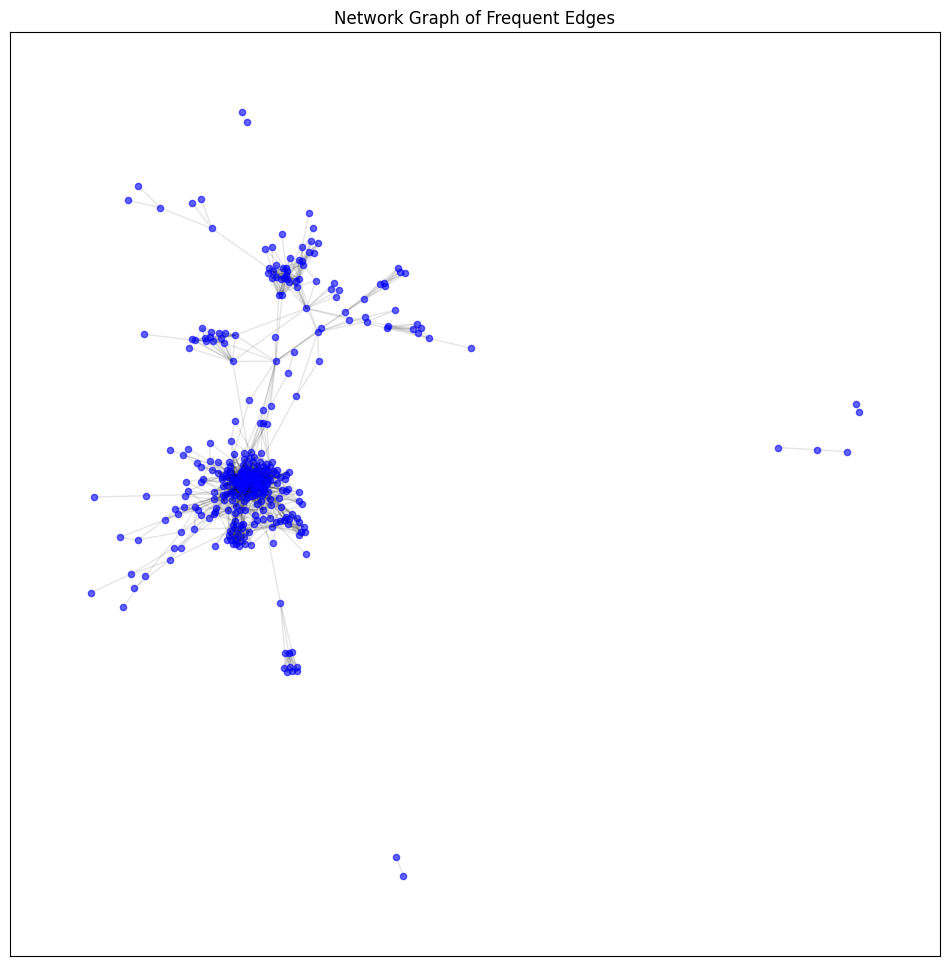

In [68]:
pos = nx.spring_layout(G)  # 使用Spring布局显示图
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Network Graph of Frequent Edges')
plt.show()

2. 用户特征的频繁模式可视化（Features）
   
对于用户特征的频繁模式，可以使用条形图来显示最常见的特征组合的支持度。

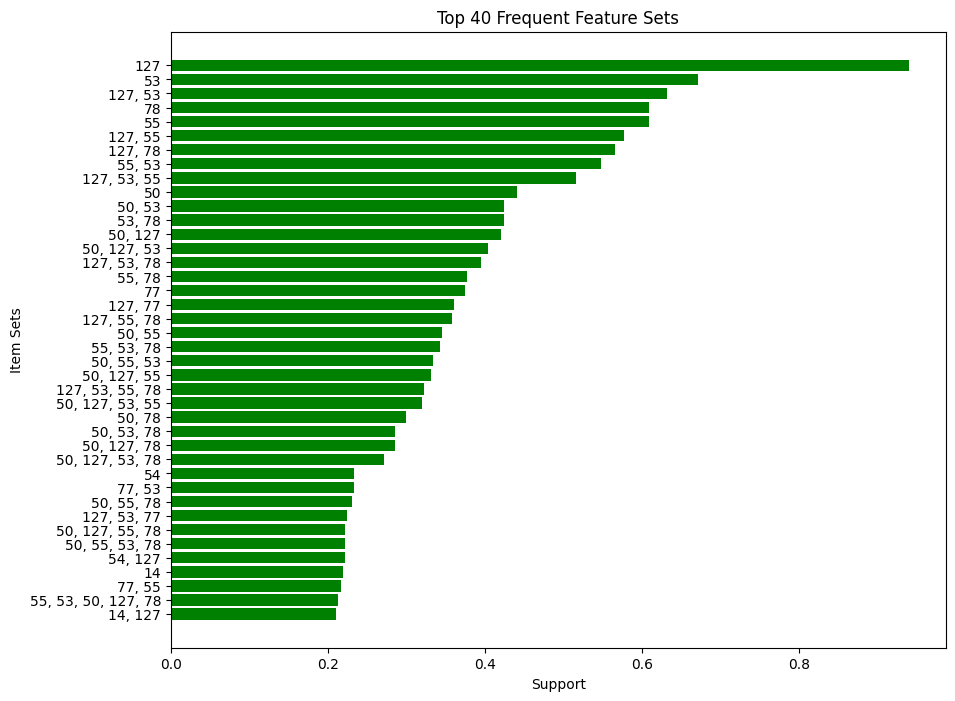

In [69]:
# 假设frequent_itemsets是特征数据的频繁项集
frequent_itemsets['itemsets_str'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(frequent_itemsets_sorted['itemsets_str'].head(40), frequent_itemsets_sorted['support'].head(40), color='green')
plt.xlabel('Support')
plt.ylabel('Item Sets')
plt.title('Top 40 Frequent Feature Sets')
plt.gca().invert_yaxis()  # 反转Y轴，使得最大的在上面
plt.show()


3. 用户圈子的频繁模式可视化（Circles）
   
对于用户圈子的频繁模式，可以通过使用热图来展示不同圈子之间的用户重叠情况。

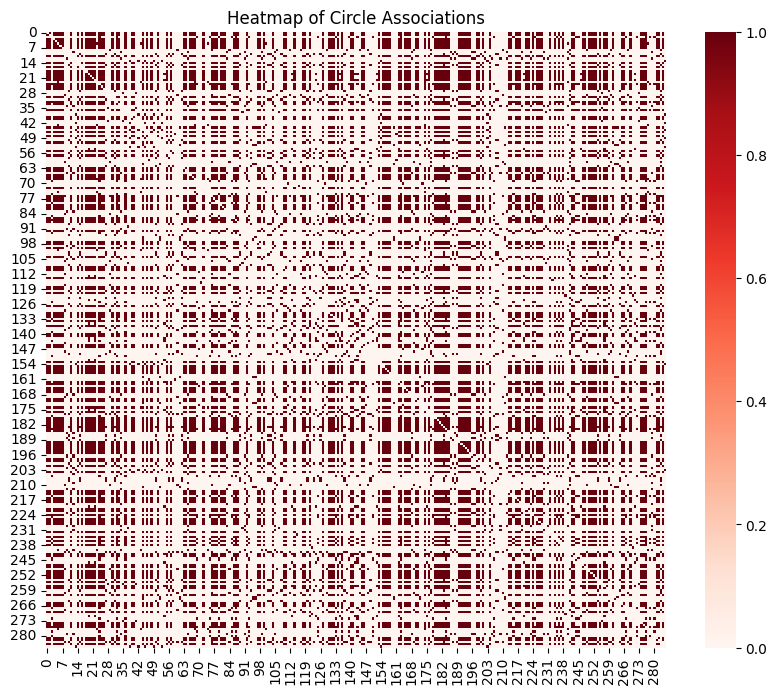

In [70]:
# 计算圈子的关联矩阵
circle_assoc_matrix = np.dot(te_ary_circle.T, te_ary_circle)
np.fill_diagonal(circle_assoc_matrix, 0)  # 对角线设置为0

# 使用Seaborn的热图显示圈子间的关联
plt.figure(figsize=(10, 8))
sns.heatmap(circle_assoc_matrix, annot=False, cmap='Reds')
plt.title('Heatmap of Circle Associations')
plt.show()
